In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
import os

In [2]:
data_dir = 'dataset/'
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

# Load and combine all data
df_list = [pd.read_csv(os.path.join(data_dir, file)) for file in csv_files]
df_combined = pd.concat(df_list, ignore_index=True)

# Check the combined dataframe
print(df_combined.shape)
print(df_combined.head())

(2830743, 79)
    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   
3                        1                            6   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   
2                             6                       6   
3                             6   

In [3]:
# Remove leading/trailing spaces from column names
df_combined.columns = df_combined.columns.str.strip()

In [4]:
# Handle missing values
df_combined = df_combined.dropna()

In [5]:
# Basic statistics
print(df_combined.describe())

       Destination Port  Flow Duration  Total Fwd Packets  \
count      2.829385e+06   2.829385e+06       2.829385e+06   
mean       8.071249e+03   1.479276e+07       9.364763e+00   
std        1.828343e+04   3.366026e+07       7.498527e+02   
min        0.000000e+00  -1.300000e+01       1.000000e+00   
25%        5.300000e+01   1.550000e+02       2.000000e+00   
50%        8.000000e+01   3.132700e+04       2.000000e+00   
75%        4.430000e+02   3.221416e+06       5.000000e+00   
max        6.553500e+04   1.200000e+08       2.197590e+05   

       Total Backward Packets  Total Length of Fwd Packets  \
count            2.829385e+06                 2.829385e+06   
mean             1.039869e+01                 5.495661e+02   
std              9.976276e+02                 9.995980e+03   
min              0.000000e+00                 0.000000e+00   
25%              1.000000e+00                 1.200000e+01   
50%              2.000000e+00                 6.200000e+01   
75%             

In [6]:
# Check label distribution
print(df_combined['Label'].value_counts())

Label
BENIGN                        2272688
DoS Hulk                       230124
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


#### Handle Null Values

In [7]:
import numpy as np
import pandas as pd

# Select only numeric columns
numeric_cols = df_combined.select_dtypes(include=[np.number]).columns

In [8]:
# Find columns with infinite values (numeric only)
inf_cols = df_combined[numeric_cols].columns[np.isinf(df_combined[numeric_cols]).any()]
print("Columns with infinite values:", inf_cols)

Columns with infinite values: Index(['Flow Bytes/s', 'Flow Packets/s'], dtype='object')


In [9]:
# Make a copy to preserve original data
df_clean = df_combined.copy()

# Handle infinite values in numeric columns only
for col in numeric_cols:
    if col in inf_cols:
        # Replace inf with max finite value or NaN
        max_finite = df_clean[col][np.isfinite(df_clean[col])].max()
        df_clean[col] = df_clean[col].replace([np.inf, -np.inf], max_finite)

In [10]:
# Check if any infinite values remain
print("Remaining infinite values:", np.isinf(df_clean[numeric_cols]).any().any())

Remaining infinite values: False


#### Label Encoding

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
encoder = LabelEncoder()

df_clean['Label'] = encoder.fit_transform(df_clean['Label'])

#### Normalizing the dataset

In [12]:
# Separate features and labels
X = df_clean.drop('Label', axis=1)
y = df_clean['Label']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
count_per_column = df_clean.count()
print(count_per_column)

Destination Port               2829385
Flow Duration                  2829385
Total Fwd Packets              2829385
Total Backward Packets         2829385
Total Length of Fwd Packets    2829385
                                ...   
Idle Mean                      2829385
Idle Std                       2829385
Idle Max                       2829385
Idle Min                       2829385
Label                          2829385
Length: 79, dtype: int64


In [14]:
column_count = len(df_clean.columns)
print("Number of columns:", column_count)

Number of columns: 79


#### Feature Selection

In [15]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select top 20 features
selector = SelectKBest(score_func=f_classif, k=20)
X_selected = selector.fit_transform(X_scaled, y)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [31 33 56 57 58 59 60 61] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


#### Data Split

In [16]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

#### Model 

In [17]:
from sklearn.svm import SVC

In [18]:
# from sklearn.svm import SVC
# import os
# import psutil

# # Set the max iterations to 100
# svm = SVC(kernel='rbf', gamma='scale', C=1.0, max_iter=100)

# # Get the current process
# p = psutil.Process(os.getpid())

# # Limit the process to use only the first two cores (this should roughly use 50% of your CPU on a 4-core system)
# p.cpu_affinity([0, 1])  # Use cores 0 and 1

# # Train the model
# svm.fit(X_train, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(max_iter=100)

In [26]:
from sklearn.svm import LinearSVC

# # Train the model with LinearSVC
svm = LinearSVC(max_iter=100) 
svm.fit(X_train, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=100)

In [31]:
import joblib

# Save the trained model
joblib.dump(svm, 'svm_model.pkl')

['svm_model.pkl']

In [28]:
# Predict on test data
y_pred = svm.predict(X_test)

In [29]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9738176471697046


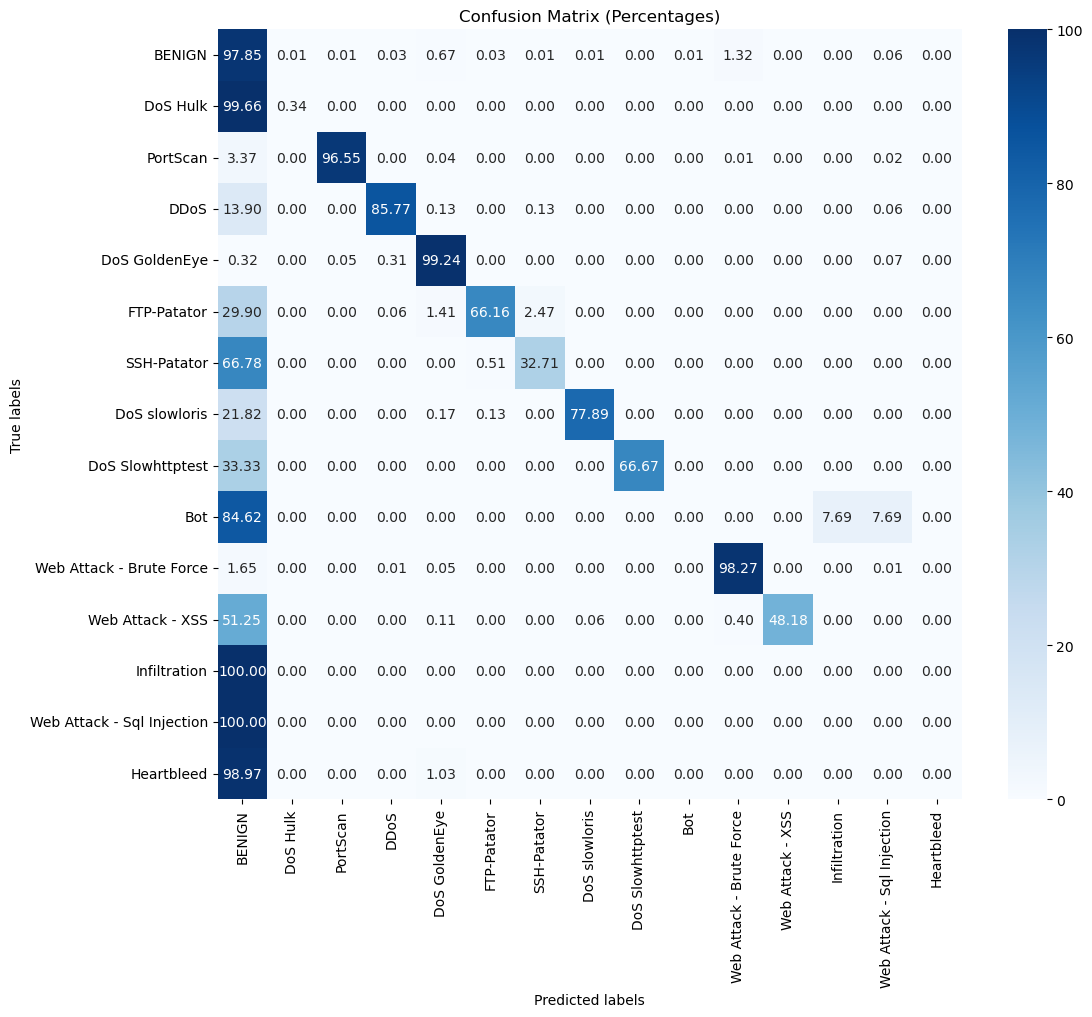

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels
class_labels = [
    'BENIGN', 'DoS Hulk', 'PortScan', 'DDoS', 'DoS GoldenEye', 'FTP-Patator', 
    'SSH-Patator', 'DoS slowloris', 'DoS Slowhttptest', 'Bot', 
    'Web Attack - Brute Force', 'Web Attack - XSS', 'Infiltration', 
    'Web Attack - Sql Injection', 'Heartbleed'
]

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Convert the confusion matrix to percentage format
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)

# Adding labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Percentages)')

# Display the plot
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.show()